In [132]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [133]:
dataset = tf.data.Dataset.range(10)
for val in dataset:
    print(val.numpy())

0
1
2
3
4
5
6
7
8
9


In [134]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift = 1)
for val in dataset:
    for i in val:
        print(i.numpy(), end=" ")
    print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 
6 7 8 9 
7 8 9 
8 9 
9 


In [135]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift = 1, drop_remainder = True)
for val in dataset:
    for i in val:
        print(i.numpy(), end=" ")
    print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 


In [136]:
# Convert to numpy
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift = 1, drop_remainder = True)
dataset = dataset.flat_map(lambda window: window.batch(5))
for val in dataset:
    print(val.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


In [137]:
# Make train/test
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift = 1, drop_remainder = True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1]))
for x,y in dataset:
    print(x.numpy(), y.numpy())

[0 1 2 3] 4
[1 2 3 4] 5
[2 3 4 5] 6
[3 4 5 6] 7
[4 5 6 7] 8
[5 6 7 8] 9


In [138]:
# Shuffle
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift = 1, drop_remainder = True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1]))
dataset = dataset.shuffle(buffer_size=10)
for x,y in dataset:
    print(x.numpy(), y.numpy())

[0 1 2 3] 4
[3 4 5 6] 7
[1 2 3 4] 5
[2 3 4 5] 6
[5 6 7 8] 9
[4 5 6 7] 8


In [139]:
# Batch
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift = 1, drop_remainder = True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1]))
dataset = dataset.shuffle(buffer_size=10)
dataset = dataset.batch(2).prefetch(buffer_size=1)
for x,y in dataset:
    print(x.numpy(), y.numpy())

[[5 6 7 8]
 [3 4 5 6]] [9 7]
[[1 2 3 4]
 [4 5 6 7]] [5 8]
[[2 3 4 5]
 [0 1 2 3]] [6 4]


In [140]:
def plot_series(time, series, format='-', start = 0, end = None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365+1, dtype="float32")
baseline = 10
amplitude = 20
slope = 0.05
noise_level = 5

series = baseline + trend(time, slope) + seasonality(time,
                    period = 200, amplitude = amplitude, phase = 0)
series += noise(time, noise_level, seed=42)


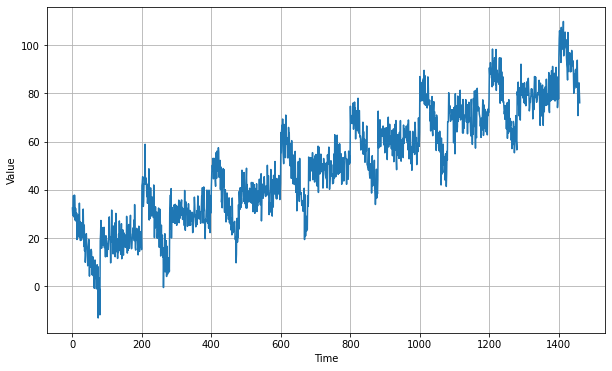

In [141]:
plt.figure(figsize=(10,6))
plot_series(time, series)

In [142]:
# Spliting train / test
split_time = 1000
time_train = time[:split_time]
series_train = series[:split_time]
time_valid = time[split_time:]
series_valid = series[split_time:]

window_size = 30
batch_size = 20
shuffle_buffer_size = 1000

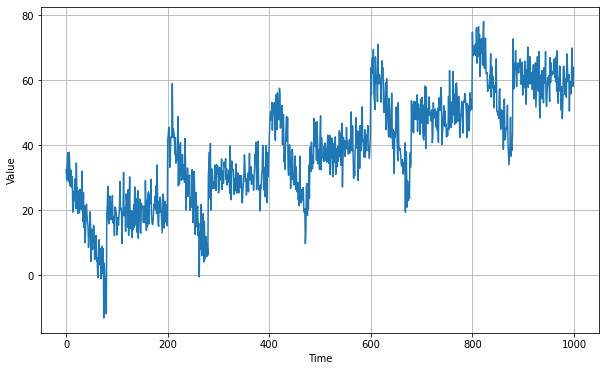

In [143]:
plt.figure(figsize=(10,6))
plot_series(time_train, series_train)

In [144]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size+1, shift=1, drop_remainder = True)
    dataset = dataset.flat_map(lambda window: 
                              window.batch(window_size+1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window:
                            (window[:-1], window[-1:]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [145]:
dataset = windowed_dataset(series_train, window_size, batch_size,
                          shuffle_buffer_size)
for val in dataset:
    print(val[0].shape, val[1].shape)
    break

(20, 30) (20, 1)


In [146]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units = 10, input_shape=(window_size,),
                         activation = 'relu'),
    tf.keras.layers.Dense(units = 10, activation = 'relu'),
    tf.keras.layers.Dense(units = 1)
])

model.summary()

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(
        lr=1e-6))
model.fit(x = dataset, epochs = 500, verbose=2)

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 10)                310       
_________________________________________________________________
dense_55 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_56 (Dense)             (None, 1)                 11        
Total params: 431
Trainable params: 431
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
49/49 - 0s - loss: 310.0468
Epoch 2/500
49/49 - 0s - loss: 94.9040
Epoch 3/500
49/49 - 0s - loss: 93.4807
Epoch 4/500
49/49 - 0s - loss: 92.0392
Epoch 5/500
49/49 - 0s - loss: 90.5156
Epoch 6/500
49/49 - 0s - loss: 89.5319
Epoch 7/500
49/49 - 0s - loss: 88.4301
Epoch 8/500
49/49 - 0s - loss: 86.8985
Epoch 9/500
49/49 - 0s - loss: 85.6852
Epoch 10/500
49/49 - 0s - loss: 8

49/49 - 0s - loss: 45.1646
Epoch 186/500
49/49 - 0s - loss: 45.2195
Epoch 187/500
49/49 - 0s - loss: 44.8985
Epoch 188/500
49/49 - 0s - loss: 45.1912
Epoch 189/500
49/49 - 0s - loss: 45.0774
Epoch 190/500
49/49 - 0s - loss: 44.9831
Epoch 191/500
49/49 - 0s - loss: 45.0295
Epoch 192/500
49/49 - 0s - loss: 44.8808
Epoch 193/500
49/49 - 0s - loss: 44.9057
Epoch 194/500
49/49 - 0s - loss: 44.8406
Epoch 195/500
49/49 - 0s - loss: 44.8733
Epoch 196/500
49/49 - 0s - loss: 44.8260
Epoch 197/500
49/49 - 0s - loss: 44.7166
Epoch 198/500
49/49 - 0s - loss: 44.6320
Epoch 199/500
49/49 - 0s - loss: 44.6647
Epoch 200/500
49/49 - 0s - loss: 44.5151
Epoch 201/500
49/49 - 0s - loss: 44.5724
Epoch 202/500
49/49 - 0s - loss: 44.5131
Epoch 203/500
49/49 - 0s - loss: 44.4856
Epoch 204/500
49/49 - 0s - loss: 44.4091
Epoch 205/500
49/49 - 0s - loss: 44.3863
Epoch 206/500
49/49 - 0s - loss: 44.3853
Epoch 207/500
49/49 - 0s - loss: 44.2954
Epoch 208/500
49/49 - 0s - loss: 44.2529
Epoch 209/500
49/49 - 0s - los

49/49 - 0s - loss: 39.7478
Epoch 386/500
49/49 - 0s - loss: 39.7129
Epoch 387/500
49/49 - 0s - loss: 39.6074
Epoch 388/500
49/49 - 0s - loss: 39.6725
Epoch 389/500
49/49 - 0s - loss: 39.6409
Epoch 390/500
49/49 - 0s - loss: 39.7111
Epoch 391/500
49/49 - 0s - loss: 39.6015
Epoch 392/500
49/49 - 0s - loss: 39.5547
Epoch 393/500
49/49 - 0s - loss: 39.4852
Epoch 394/500
49/49 - 0s - loss: 39.5776
Epoch 395/500
49/49 - 0s - loss: 39.3306
Epoch 396/500
49/49 - 0s - loss: 39.4973
Epoch 397/500
49/49 - 0s - loss: 39.5900
Epoch 398/500
49/49 - 0s - loss: 39.5540
Epoch 399/500
49/49 - 0s - loss: 39.5483
Epoch 400/500
49/49 - 0s - loss: 39.5096
Epoch 401/500
49/49 - 0s - loss: 39.4650
Epoch 402/500
49/49 - 0s - loss: 39.4952
Epoch 403/500
49/49 - 0s - loss: 39.4496
Epoch 404/500
49/49 - 0s - loss: 39.4955
Epoch 405/500
49/49 - 0s - loss: 39.4339
Epoch 406/500
49/49 - 0s - loss: 39.3605
Epoch 407/500
49/49 - 0s - loss: 39.3757
Epoch 408/500
49/49 - 0s - loss: 39.4374
Epoch 409/500
49/49 - 0s - los

In [147]:
forecast = []
for time_index in range(len(series) - window_size):
    input_data = series[time_index:time_index+window_size]
    output_data = model.predict(np.array(input_data)[None,:])
    forecast.append(output_data[0][0])


In [148]:
forecast = np.array(forecast)

In [149]:
print(series_valid.shape)
print(forecast[split_time-window_size:].shape)

(461,)
(461,)


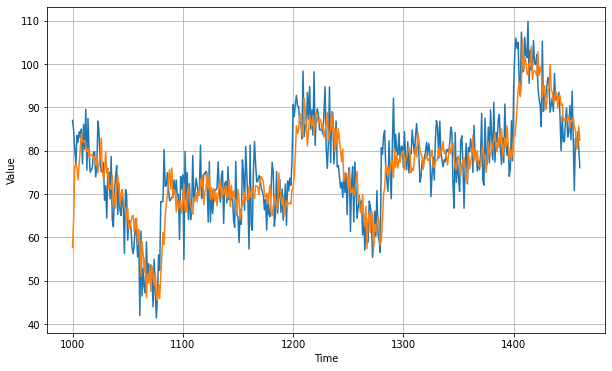

In [150]:
plt.figure(figsize=(10,6))
time = np.arange(4 * 365+1, dtype="float32")
plot_series(time_valid, series_valid)
plot_series(time_valid, forecast[split_time-window_size:])

In [151]:
tf.keras.metrics.mean_absolute_error(series[window_size:], forecast).numpy()

4.8984284

In [155]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units = 10, input_shape=(window_size,),
                         activation = 'relu'),
    tf.keras.layers.Dense(units = 10, activation = 'relu'),
    tf.keras.layers.Dense(units = 1)
])

model.summary()

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 40))

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(
        lr=1e-8, momentum=0.9))
history = model.fit(x = dataset, epochs = 100, verbose=2)

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 10)                310       
_________________________________________________________________
dense_61 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_62 (Dense)             (None, 1)                 11        
Total params: 431
Trainable params: 431
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
49/49 - 0s - loss: 922.9056
Epoch 2/100
49/49 - 0s - loss: 321.1852
Epoch 3/100
49/49 - 0s - loss: 155.8322
Epoch 4/100
49/49 - 0s - loss: 109.3521
Epoch 5/100
49/49 - 0s - loss: 93.5544
Epoch 6/100
49/49 - 0s - loss: 88.1350
Epoch 7/100
49/49 - 0s - loss: 85.8598
Epoch 8/100
49/49 - 0s - loss: 84.9184
Epoch 9/100
49/49 - 0s - loss: 84.4341
Epoch 10/100
49/49 - 0s - loss

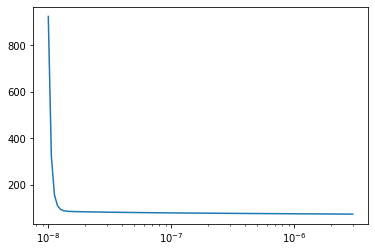

In [158]:
lrs = 1e-8 * 10 ** (np.arange(100) / 40)
plt.semilogx(lrs, history.history['loss'])

In [159]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units = 10, input_shape=(window_size,),
                         activation = 'relu'),
    tf.keras.layers.Dense(units = 10, activation = 'relu'),
    tf.keras.layers.Dense(units = 1)
])

model.summary()

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(
        lr=8e-6, momentum=0.9))
history = model.fit(x = dataset, epochs = 500, verbose=2)

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_63 (Dense)             (None, 10)                310       
_________________________________________________________________
dense_64 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_65 (Dense)             (None, 1)                 11        
Total params: 431
Trainable params: 431
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
49/49 - 0s - loss: 119.6239
Epoch 2/500
49/49 - 0s - loss: 54.4109
Epoch 3/500
49/49 - 0s - loss: 56.5477
Epoch 4/500
49/49 - 0s - loss: 48.0912
Epoch 5/500
49/49 - 0s - loss: 42.7508
Epoch 6/500
49/49 - 0s - loss: 41.5455
Epoch 7/500
49/49 - 0s - loss: 49.8227
Epoch 8/500
49/49 - 0s - loss: 41.9495
Epoch 9/500
49/49 - 0s - loss: 38.8926
Epoch 10/500
49/49 - 0s - loss: 4

49/49 - 0s - loss: 32.2809
Epoch 186/500
49/49 - 0s - loss: 32.5464
Epoch 187/500
49/49 - 0s - loss: 35.0630
Epoch 188/500
49/49 - 0s - loss: 32.2617
Epoch 189/500
49/49 - 0s - loss: 32.9395
Epoch 190/500
49/49 - 0s - loss: 31.7911
Epoch 191/500
49/49 - 0s - loss: 33.4086
Epoch 192/500
49/49 - 0s - loss: 32.9209
Epoch 193/500
49/49 - 0s - loss: 33.6435
Epoch 194/500
49/49 - 0s - loss: 32.3462
Epoch 195/500
49/49 - 0s - loss: 31.7237
Epoch 196/500
49/49 - 0s - loss: 33.4513
Epoch 197/500
49/49 - 0s - loss: 33.5567
Epoch 198/500
49/49 - 0s - loss: 33.0782
Epoch 199/500
49/49 - 0s - loss: 33.4542
Epoch 200/500
49/49 - 0s - loss: 32.9869
Epoch 201/500
49/49 - 0s - loss: 32.3403
Epoch 202/500
49/49 - 0s - loss: 32.7903
Epoch 203/500
49/49 - 0s - loss: 33.1902
Epoch 204/500
49/49 - 0s - loss: 33.3118
Epoch 205/500
49/49 - 0s - loss: 32.7985
Epoch 206/500
49/49 - 0s - loss: 35.0890
Epoch 207/500
49/49 - 0s - loss: 41.8250
Epoch 208/500
49/49 - 0s - loss: 34.3379
Epoch 209/500
49/49 - 0s - los

49/49 - 0s - loss: 32.4048
Epoch 386/500
49/49 - 0s - loss: 31.4410
Epoch 387/500
49/49 - 0s - loss: 34.5171
Epoch 388/500
49/49 - 0s - loss: 31.8140
Epoch 389/500
49/49 - 0s - loss: 30.9390
Epoch 390/500
49/49 - 0s - loss: 29.5187
Epoch 391/500
49/49 - 0s - loss: 29.5280
Epoch 392/500
49/49 - 0s - loss: 30.4953
Epoch 393/500
49/49 - 0s - loss: 32.2938
Epoch 394/500
49/49 - 0s - loss: 33.8520
Epoch 395/500
49/49 - 0s - loss: 32.8614
Epoch 396/500
49/49 - 0s - loss: 34.0620
Epoch 397/500
49/49 - 0s - loss: 32.6356
Epoch 398/500
49/49 - 0s - loss: 31.5111
Epoch 399/500
49/49 - 0s - loss: 31.4345
Epoch 400/500
49/49 - 0s - loss: 31.1479
Epoch 401/500
49/49 - 0s - loss: 33.1724
Epoch 402/500
49/49 - 0s - loss: 30.2966
Epoch 403/500
49/49 - 0s - loss: 29.5303
Epoch 404/500
49/49 - 0s - loss: 35.6140
Epoch 405/500
49/49 - 0s - loss: 30.6842
Epoch 406/500
49/49 - 0s - loss: 32.1755
Epoch 407/500
49/49 - 0s - loss: 30.6115
Epoch 408/500
49/49 - 0s - loss: 30.1583
Epoch 409/500
49/49 - 0s - los

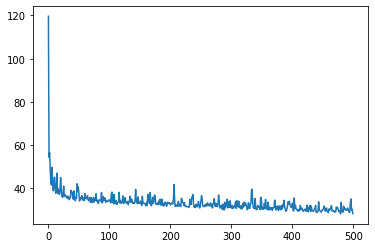

In [161]:
loss = history.history['loss']
epochs = np.arange(500)
plt.plot(epochs, loss, label = 'Training Loss')

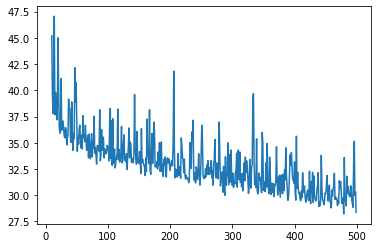

In [162]:
loss = history.history['loss']
epochs = np.arange(10, 500)
plt.plot(epochs, loss[10:], label = 'Training Loss')

In [ ]:
forecast = []
for time_index in range(len(series) - window_size):
    input_data = series[time_index:time_index+window_size]
    output_data = model.predict(np.array(input_data)[None,:])
    forecast.append(output_data[0][0])
forecast = np.array(forecast)